In [1]:
# Install necessary libraries
!pip install xgboost
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.1 MB/s eta 0:00:00


In [2]:
# Update scikit-learn and xgboost to the latest versions
!pip install --upgrade scikit-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from google.colab import files

# Upload development and validation data
uploaded = files.upload()  # This will prompt you to upload the development and validation data CSV files

# Load development data
dev_data = pd.read_csv('/content/Dev_data_to_be_shared.csv')  # Change filename if necessary
val_data = pd.read_csv('/content/validation_data_to_be_shared.csv')  # Change filename if necessary

# Check the data structure
print("Development Data:")
print(dev_data.head())
print(dev_data.info())

print("\nValidation Data:")
print(val_data.head())
print(val_data.info())

Development Data:
   account_number  bad_flag  onus_attribute_1  transaction_attribute_1  \
0               1         0               NaN                      NaN   
1               2         0          221000.0                      0.0   
2               3         0           25000.0                      0.0   
3               4         0           86000.0                      0.0   
4               5         0          215000.0                      0.0   

   transaction_attribute_2  transaction_attribute_3  transaction_attribute_4  \
0                      NaN                      NaN                      NaN   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                      0.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   transaction_attribute_5  transaction_attribute_6  tra

<ipython-input-4-ebcce7dcf7fe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bad_flag', data=dev_data, palette='viridis')


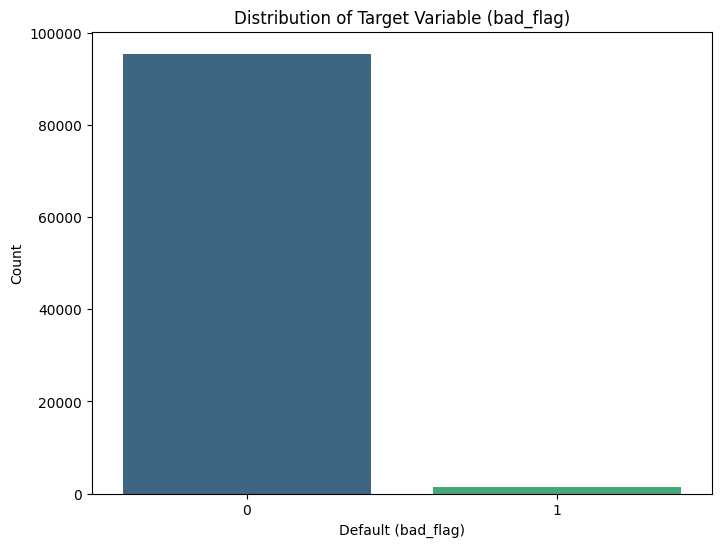

Missing values per column:
 onus_attribute_1           25231
transaction_attribute_1    25231
transaction_attribute_2    25231
transaction_attribute_3    25231
transaction_attribute_4    25231
                           ...  
onus_attribute_44          85196
onus_attribute_45          85196
onus_attribute_46          85196
onus_attribute_47          85196
onus_attribute_48          85196
Length: 1185, dtype: int64


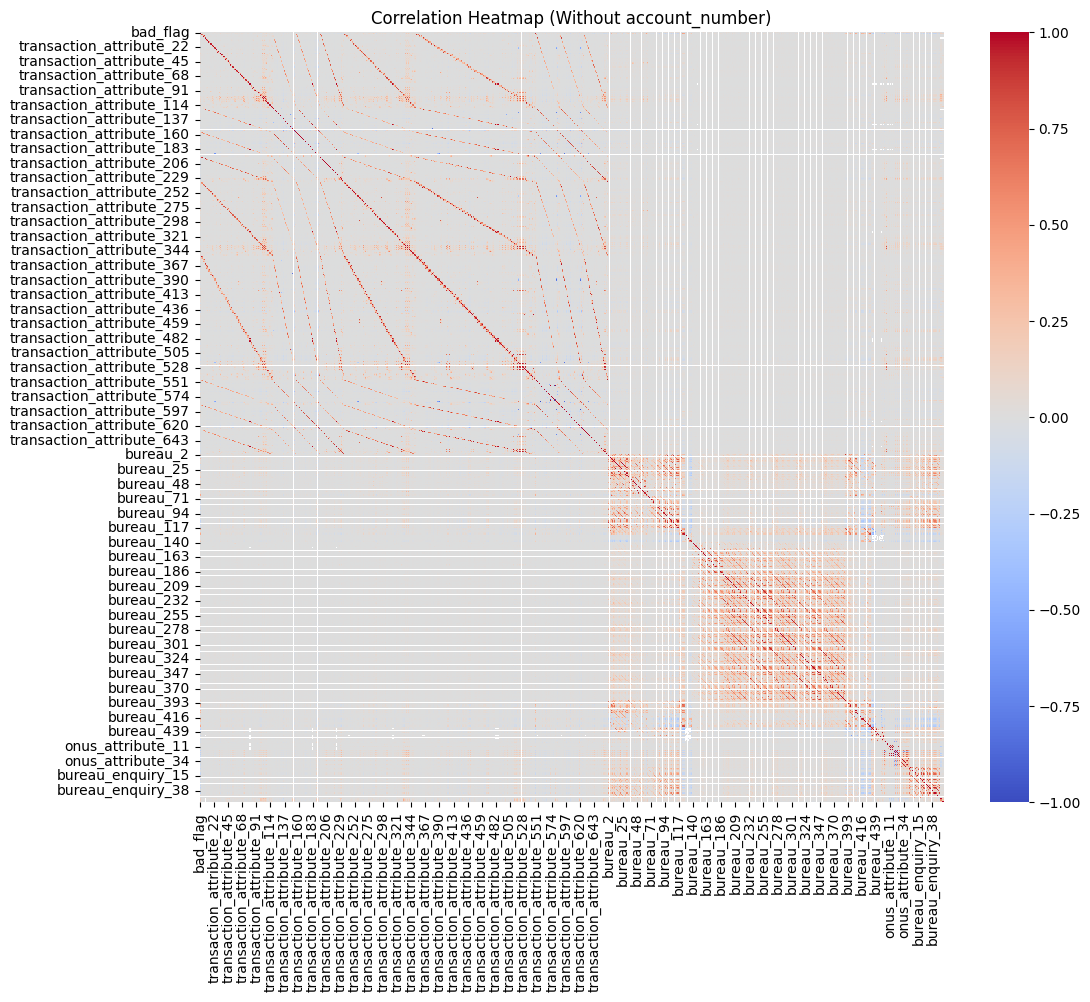

Index(['account_number', 'bad_flag', 'onus_attribute_1',
       'transaction_attribute_1', 'transaction_attribute_2',
       'transaction_attribute_3', 'transaction_attribute_4',
       'transaction_attribute_5', 'transaction_attribute_6',
       'transaction_attribute_7',
       ...
       'bureau_enquiry_47', 'bureau_enquiry_48', 'bureau_enquiry_49',
       'bureau_enquiry_50', 'onus_attribute_43', 'onus_attribute_44',
       'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47',
       'onus_attribute_48'],
      dtype='object', length=1216)


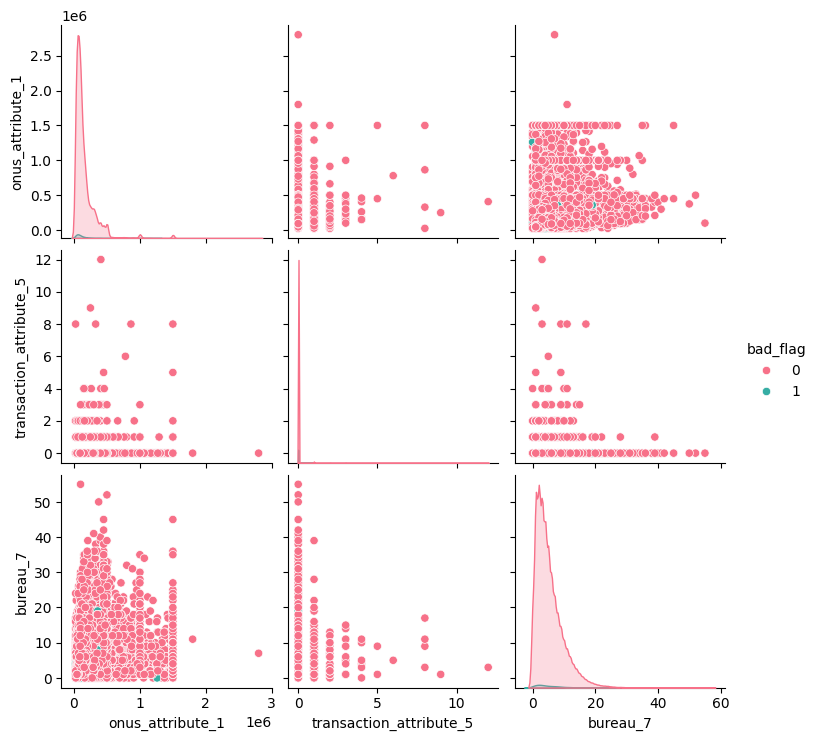

In [4]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='bad_flag', data=dev_data, palette='viridis')
plt.title("Distribution of Target Variable (bad_flag)")
plt.xlabel("Default (bad_flag)")
plt.ylabel("Count")
plt.show()

# Check for missing values
missing_values = dev_data.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Correlation heatmap (excluding 'account_number')
plt.figure(figsize=(12, 10))
# Drop 'account_number' from the dataset before calculating correlations
correlation_matrix = dev_data.drop(['account_number'], axis=1).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap (Without account_number)")
plt.show()

# Pairplot for a subset of important features
# First, confirm which features exist in your dataset
print(dev_data.columns)

# Use actual column names from your dataset (excluding account_number)
selected_features = ['onus_attribute_1', 'transaction_attribute_5', 'bureau_7', 'bad_flag']  # Adjust based on your dataset

sns.pairplot(dev_data[selected_features], hue='bad_flag', palette='husl')
plt.show()


In [5]:
# Handling missing values
for col in dev_data.columns:
    if dev_data[col].isnull().sum() > 0:
        if dev_data[col].dtype == 'object':
            dev_data[col].fillna(dev_data[col].mode()[0], inplace=True)
        else:
            dev_data[col].fillna(dev_data[col].median(), inplace=True)

# Confirm there are no missing values
print("Missing values after imputation:\n", dev_data.isnull().sum().sum())

# Feature Scaling for numerical variables
scaler = MinMaxScaler()
numerical_features = dev_data.select_dtypes(include=['float64', 'int64']).columns.drop(['bad_flag', 'account_number'])
dev_data[numerical_features] = scaler.fit_transform(dev_data[numerical_features])

# Apply the same transformations to validation data
val_data[numerical_features] = scaler.transform(val_data[numerical_features])

Streaming output truncated to the last 5000 lines.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dev_data[col].fillna(dev_data[col].median(), inplace=True)
<ipython-input-5-4b7197f624aa>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dev_data[col].fillna(dev_data[col].median(), inplace=True)
<ipython-input-5-4b7197f624aa>:7: FutureWarning: A value is tryi

Missing values after imputation:
 193612


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [6]:
# Example of balance to limit ratio feature creation (update column names based on your dataset)
dev_data['balance_to_limit_ratio'] = dev_data['onus_attribute_10'] / (dev_data['onus_attribute_15'] + 1e-5)
val_data['balance_to_limit_ratio'] = val_data['onus_attribute_10'] / (val_data['onus_attribute_15'] + 1e-5)

# Correlation of features with the target variable (excluding 'account_number' and 'bad_flag')
correlation_matrix = dev_data.drop(['account_number', 'bad_flag'], axis=1).corr()
correlated_features = correlation_matrix.abs().sort_values(by='balance_to_limit_ratio', ascending=False)
print("Top correlated features with balance_to_limit_ratio:\n", correlated_features.head(10))

# Selecting top 10 features (excluding 'bad_flag' itself)
# Manually pick features from the top correlated features
top_features = ['onus_attribute_10', 'transaction_attribute_5', 'bureau_7', 'balance_to_limit_ratio']  # Example

# Create feature matrix and target variable
X = dev_data[top_features]
y = dev_data['bad_flag']

# Display selected features
print("Selected features for the model:\n", X.head())


<ipython-input-6-eb2849068378>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dev_data['balance_to_limit_ratio'] = dev_data['onus_attribute_10'] / (dev_data['onus_attribute_15'] + 1e-5)
<ipython-input-6-eb2849068378>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_data['balance_to_limit_ratio'] = val_data['onus_attribute_10'] / (val_data['onus_attribute_15'] + 1e-5)


Top correlated features with balance_to_limit_ratio:
                         onus_attribute_1  transaction_attribute_1  \
balance_to_limit_ratio          0.001343                 0.000958   
onus_attribute_19               0.016688                 0.001761   
onus_attribute_10               0.023790                 0.000885   
onus_attribute_22               0.061678                 0.001620   
onus_attribute_13               0.063563                 0.001616   
onus_attribute_16               0.064914                 0.001604   
onus_attribute_25               0.064877                 0.001604   
onus_attribute_35               0.096306                 0.000381   
onus_attribute_41               0.096895                 0.000272   
onus_attribute_42               0.064754                 0.000337   

                        transaction_attribute_2  transaction_attribute_3  \
balance_to_limit_ratio                 0.000837                 0.002717   
onus_attribute_19                 

In [7]:
# Update scikit-learn and xgboost to the latest versions
!pip install --upgrade scikit-learn xgboost

In [8]:
!pip install imbalanced-learn
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.6 MB/s eta 0:00:00


In [9]:
import lightgbm as lgb
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model as baseline
log_reg = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
log_reg.fit(X_train_smote, y_train_smote)

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=8)
rf.fit(X_train_smote, y_train_smote)

# Train an XGBoost model (advanced)
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)

# Train a LightGBM model (advanced)
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train_smote, y_train_smote)

# Evaluate the models
print("Logistic Regression Report:")
print(classification_report(y_test, log_reg.predict(X_test)))

print("\nRandom Forest Report:")
print(classification_report(y_test, rf.predict(X_test)))

print("\nXGBoost Report:")
print(classification_report(y_test, xgb.predict(X_test)))

print("\nLightGBM Report:")
print(classification_report(y_test, lgbm.predict(X_test)))

# Logistic Regression Predictions
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for Logistic Regression
y_pred_lr = log_reg.predict(X_test)  # Predicted classes for Logistic Regression

# Random Forest Predictions
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Predicted probabilities for Random Forest
y_pred_rf = rf.predict(X_test)  # Predicted classes for Random Forest

# XGBoost Predictions
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Predicted probabilities for XGBoost
y_pred_xgb = xgb.predict(X_test)  # Predicted classes for XGBoost

# LightGBM Predictions
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]  # Predicted probabilities for LightGBM
y_pred_lgbm = lgbm.predict(X_test)  # Predicted classes for LightGBM


[LightGBM] [Info] Number of positive: 76346, number of negative: 76346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 152692, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.99      0.40      0.57     19088
           1       0.02      0.74      0.03       274

    accuracy                           0.40     19362
   macro avg       0.50      0.57      0.30     19362
weighted avg       0.98      0.40      0.56     19362


Random Forest Report:
              precision    recall  f1-score   support

           0       0.99      0.61      0.76     19088
           

=== Logistic Regression Model Evaluation ===
Accuracy (LR): 0.4025410598078711
Precision (LR): 0.017350427350427352
Recall (LR): 0.7408759124087592
F1 Score (LR): 0.033906798062468685
ROC AUC Score (LR): 0.5964287189260957

Confusion Matrix (LR):
 [[ 7591 11497]
 [   71   203]]

Classification Report (LR):
               precision    recall  f1-score   support

           0       0.99      0.40      0.57     19088
           1       0.02      0.74      0.03       274

    accuracy                           0.40     19362
   macro avg       0.50      0.57      0.30     19362
weighted avg       0.98      0.40      0.56     19362


=== Random Forest Model Evaluation ===
Accuracy (RF): 0.6099576490032022
Precision (RF): 0.017374005305039786
Recall (RF): 0.4781021897810219
F1 Score (RF): 0.033529562324033785
ROC AUC Score (RF): 0.5840876830171132

Confusion Matrix (RF):
 [[11679  7409]
 [  143   131]]

Classification Report (RF):
               precision    recall  f1-score   support

     

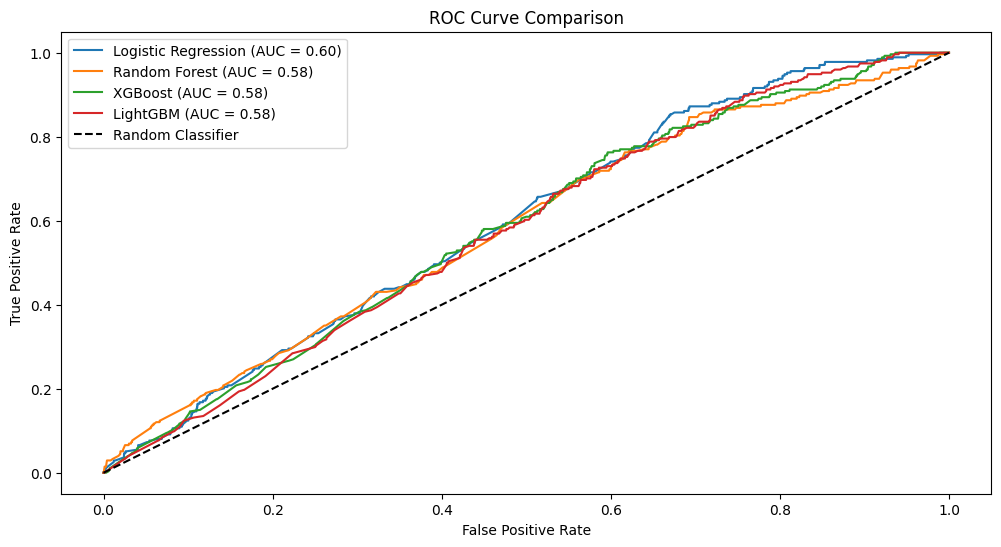

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Logistic Regression Predictions
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for Logistic Regression
y_pred_lr = log_reg.predict(X_test)  # Predicted classes for Logistic Regression

# Random Forest Predictions
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Predicted probabilities for Random Forest
y_pred_rf = rf.predict(X_test)  # Predicted classes for Random Forest

# XGBoost Predictions
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Predicted probabilities for XGBoost
y_pred_xgb = xgb.predict(X_test)  # Predicted classes for XGBoost

# Logistic Regression Evaluation
print("=== Logistic Regression Model Evaluation ===")
print("Accuracy (LR):", accuracy_score(y_test, y_pred_lr))
print("Precision (LR):", precision_score(y_test, y_pred_lr))
print("Recall (LR):", recall_score(y_test, y_pred_lr))
print("F1 Score (LR):", f1_score(y_test, y_pred_lr))
print("ROC AUC Score (LR):", roc_auc_score(y_test, y_pred_proba_lr))
print("\nConfusion Matrix (LR):\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report (LR):\n", classification_report(y_test, y_pred_lr))

# Random Forest Evaluation
print("\n=== Random Forest Model Evaluation ===")
print("Accuracy (RF):", accuracy_score(y_test, y_pred_rf))
print("Precision (RF):", precision_score(y_test, y_pred_rf))
print("Recall (RF):", recall_score(y_test, y_pred_rf))
print("F1 Score (RF):", f1_score(y_test, y_pred_rf))
print("ROC AUC Score (RF):", roc_auc_score(y_test, y_pred_proba_rf))
print("\nConfusion Matrix (RF):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (RF):\n", classification_report(y_test, y_pred_rf))

# XGBoost Evaluation
print("\n=== XGBoost Model Evaluation ===")
print("Accuracy (XGB):", accuracy_score(y_test, y_pred_xgb))
print("Precision (XGB):", precision_score(y_test, y_pred_xgb))
print("Recall (XGB):", recall_score(y_test, y_pred_xgb))
print("F1 Score (XGB):", f1_score(y_test, y_pred_xgb))
print("ROC AUC Score (XGB):", roc_auc_score(y_test, y_pred_proba_xgb))
print("\nConfusion Matrix (XGB):\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report (XGB):\n", classification_report(y_test, y_pred_xgb))

# LightGBM Evaluation
print("\n=== LightGBM Model Evaluation ===")
print("Accuracy (LGBM):", accuracy_score(y_test, y_pred_lgbm))
print("Precision (LGBM):", precision_score(y_test, y_pred_lgbm))
print("Recall (LGBM):", recall_score(y_test, y_pred_lgbm))
print("F1 Score (LGBM):", f1_score(y_test, y_pred_lgbm))
print("ROC AUC Score (LGBM):", roc_auc_score(y_test, y_pred_proba_lgbm))
print("\nConfusion Matrix (LGBM):\n", confusion_matrix(y_test, y_pred_lgbm))
print("\nClassification Report (LGBM):\n", classification_report(y_test, y_pred_lgbm))

# Plotting ROC Curves for all three models
plt.figure(figsize=(12, 6))

# ROC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba_lr)))

# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba_rf)))

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba_xgb)))

# ROC for LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM (AUC = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba_lgbm)))


# Random Classifier Line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


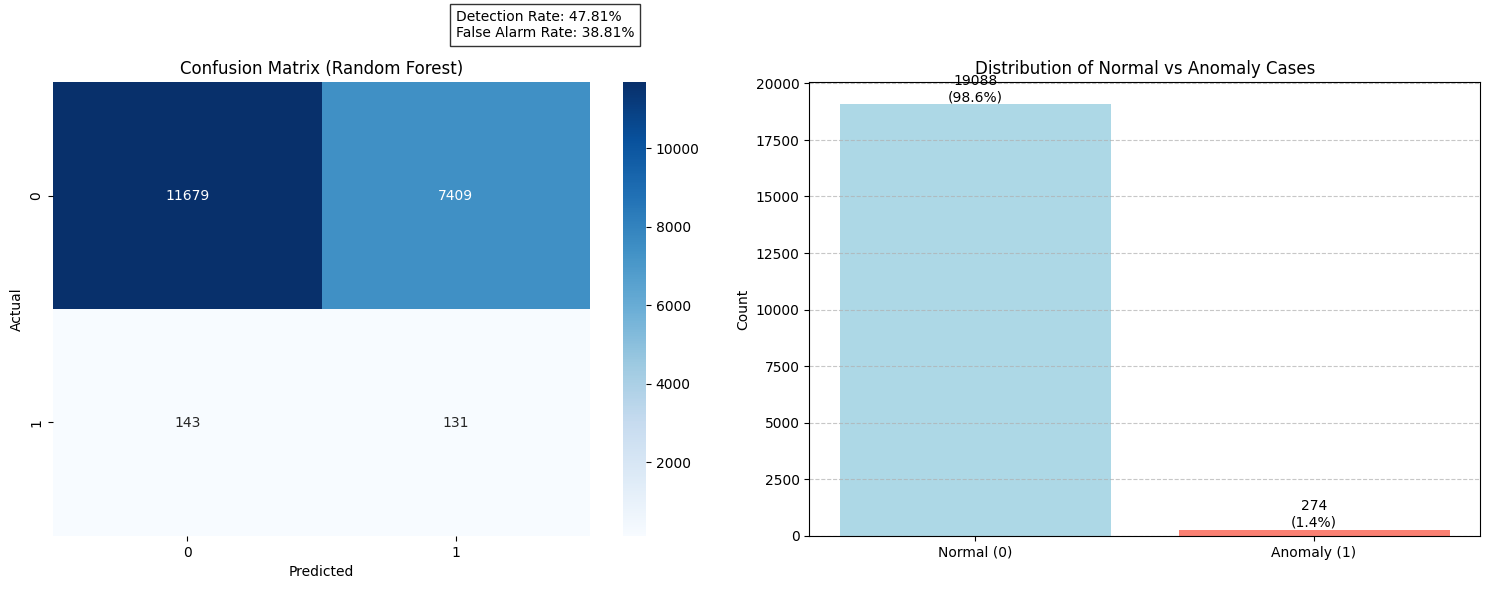


Detailed Metrics:
Total Samples: 19362
Normal Cases: 19088 (98.6%)
Anomaly Cases: 274 (1.4%)

Confusion Matrix Details:
True Negatives: 11679
False Positives: 7409
False Negatives: 143
True Positives: 131
Detection Rate: 47.81%
False Alarm Rate: 38.81%


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Confusion Matrix Heatmap
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix (Random Forest)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Calculate and display detection rates
tn, fp, fn, tp = cm_rf.ravel()
detection_rate = tp / (tp + fn) * 100
false_alarm_rate = fp / (fp + tn) * 100

text_box = f'Detection Rate: {detection_rate:.2f}%\nFalse Alarm Rate: {false_alarm_rate:.2f}%'
ax1.text(1.5, -0.2, text_box, bbox=dict(facecolor='white', alpha=0.8))

# Plot 2: Anomaly Count Distribution
anomaly_counts = {
    'Normal (0)': (y_test == 0).sum(),
    'Anomaly (1)': (y_test == 1).sum()
}

bars = ax2.bar(anomaly_counts.keys(), anomaly_counts.values(), color=['lightblue', 'salmon'])
ax2.set_title('Distribution of Normal vs Anomaly Cases')
ax2.set_ylabel('Count')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(y_test)*100:.1f}%)',
             ha='center', va='bottom')

# Add grid to the anomaly count plot
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics:")
print(f"Total Samples: {len(y_test)}")
print(f"Normal Cases: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"Anomaly Cases: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")
print(f"\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Detection Rate: {detection_rate:.2f}%")
print(f"False Alarm Rate: {false_alarm_rate:.2f}%")

[LightGBM] [Info] Number of positive: 76346, number of negative: 76346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 152692, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


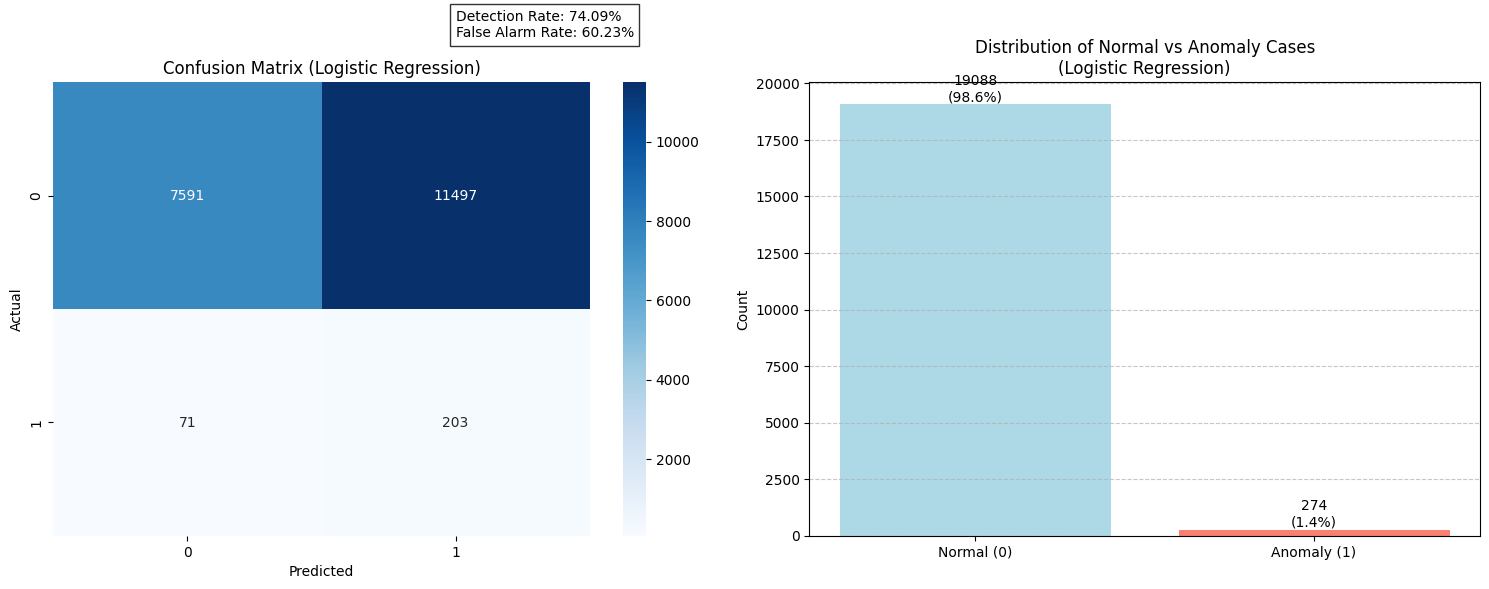


Detailed Metrics for Logistic Regression:
Total Samples: 19362
Normal Cases: 19088 (98.6%)
Anomaly Cases: 274 (1.4%)

Confusion Matrix Details:
True Negatives: 7591
False Positives: 11497
False Negatives: 71
True Positives: 203
Detection Rate: 74.09%
False Alarm Rate: 60.23%
--------------------------------------------------


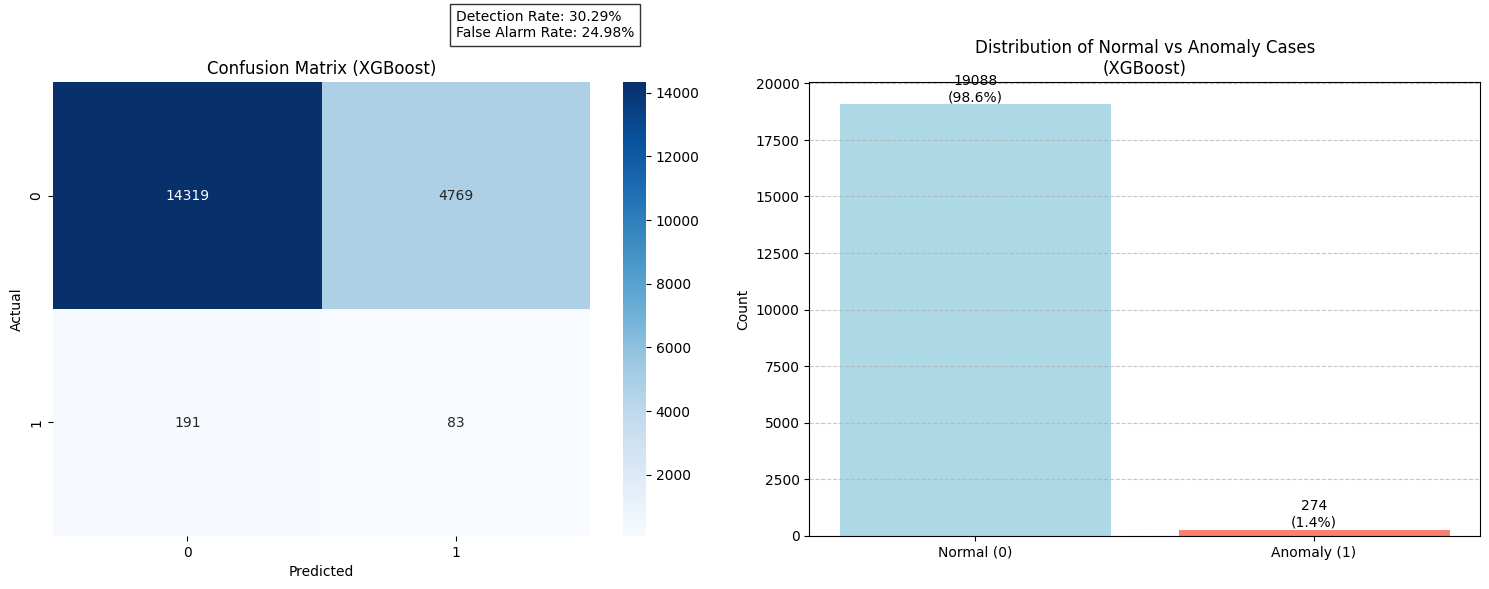


Detailed Metrics for XGBoost:
Total Samples: 19362
Normal Cases: 19088 (98.6%)
Anomaly Cases: 274 (1.4%)

Confusion Matrix Details:
True Negatives: 14319
False Positives: 4769
False Negatives: 191
True Positives: 83
Detection Rate: 30.29%
False Alarm Rate: 24.98%
--------------------------------------------------


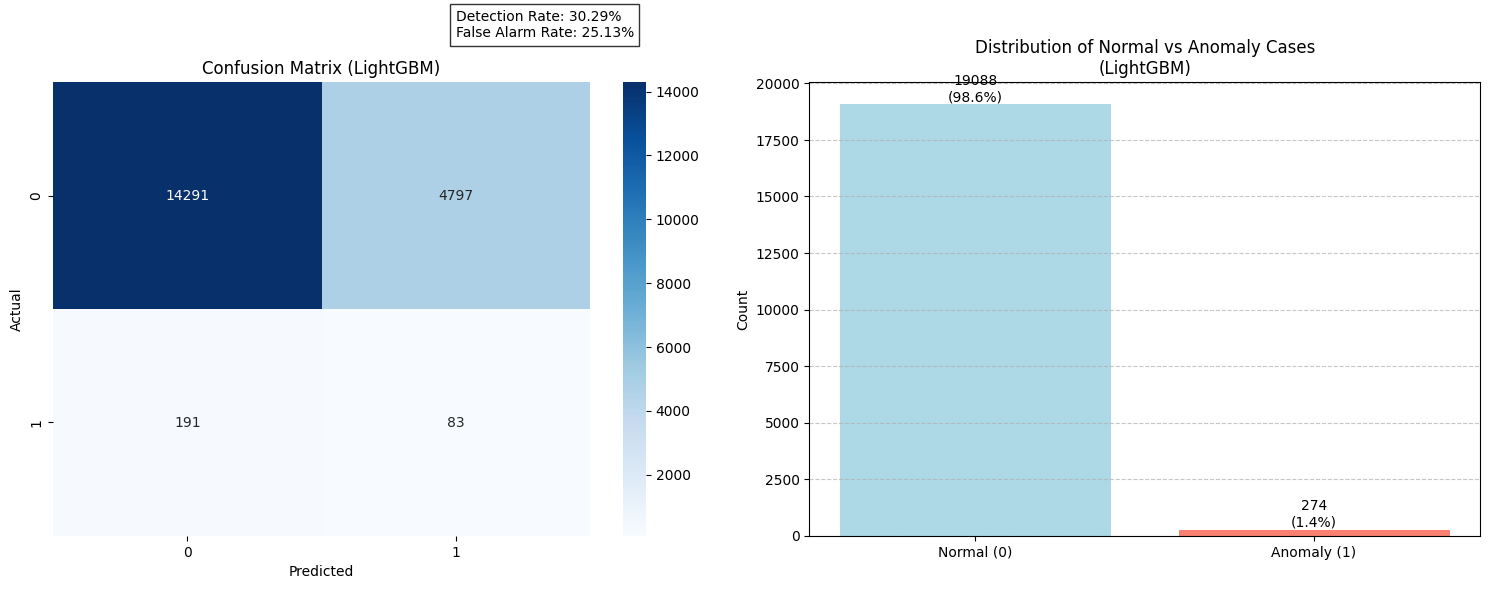


Detailed Metrics for LightGBM:
Total Samples: 19362
Normal Cases: 19088 (98.6%)
Anomaly Cases: 274 (1.4%)

Confusion Matrix Details:
True Negatives: 14291
False Positives: 4797
False Negatives: 191
True Positives: 83
Detection Rate: 30.29%
False Alarm Rate: 25.13%
--------------------------------------------------


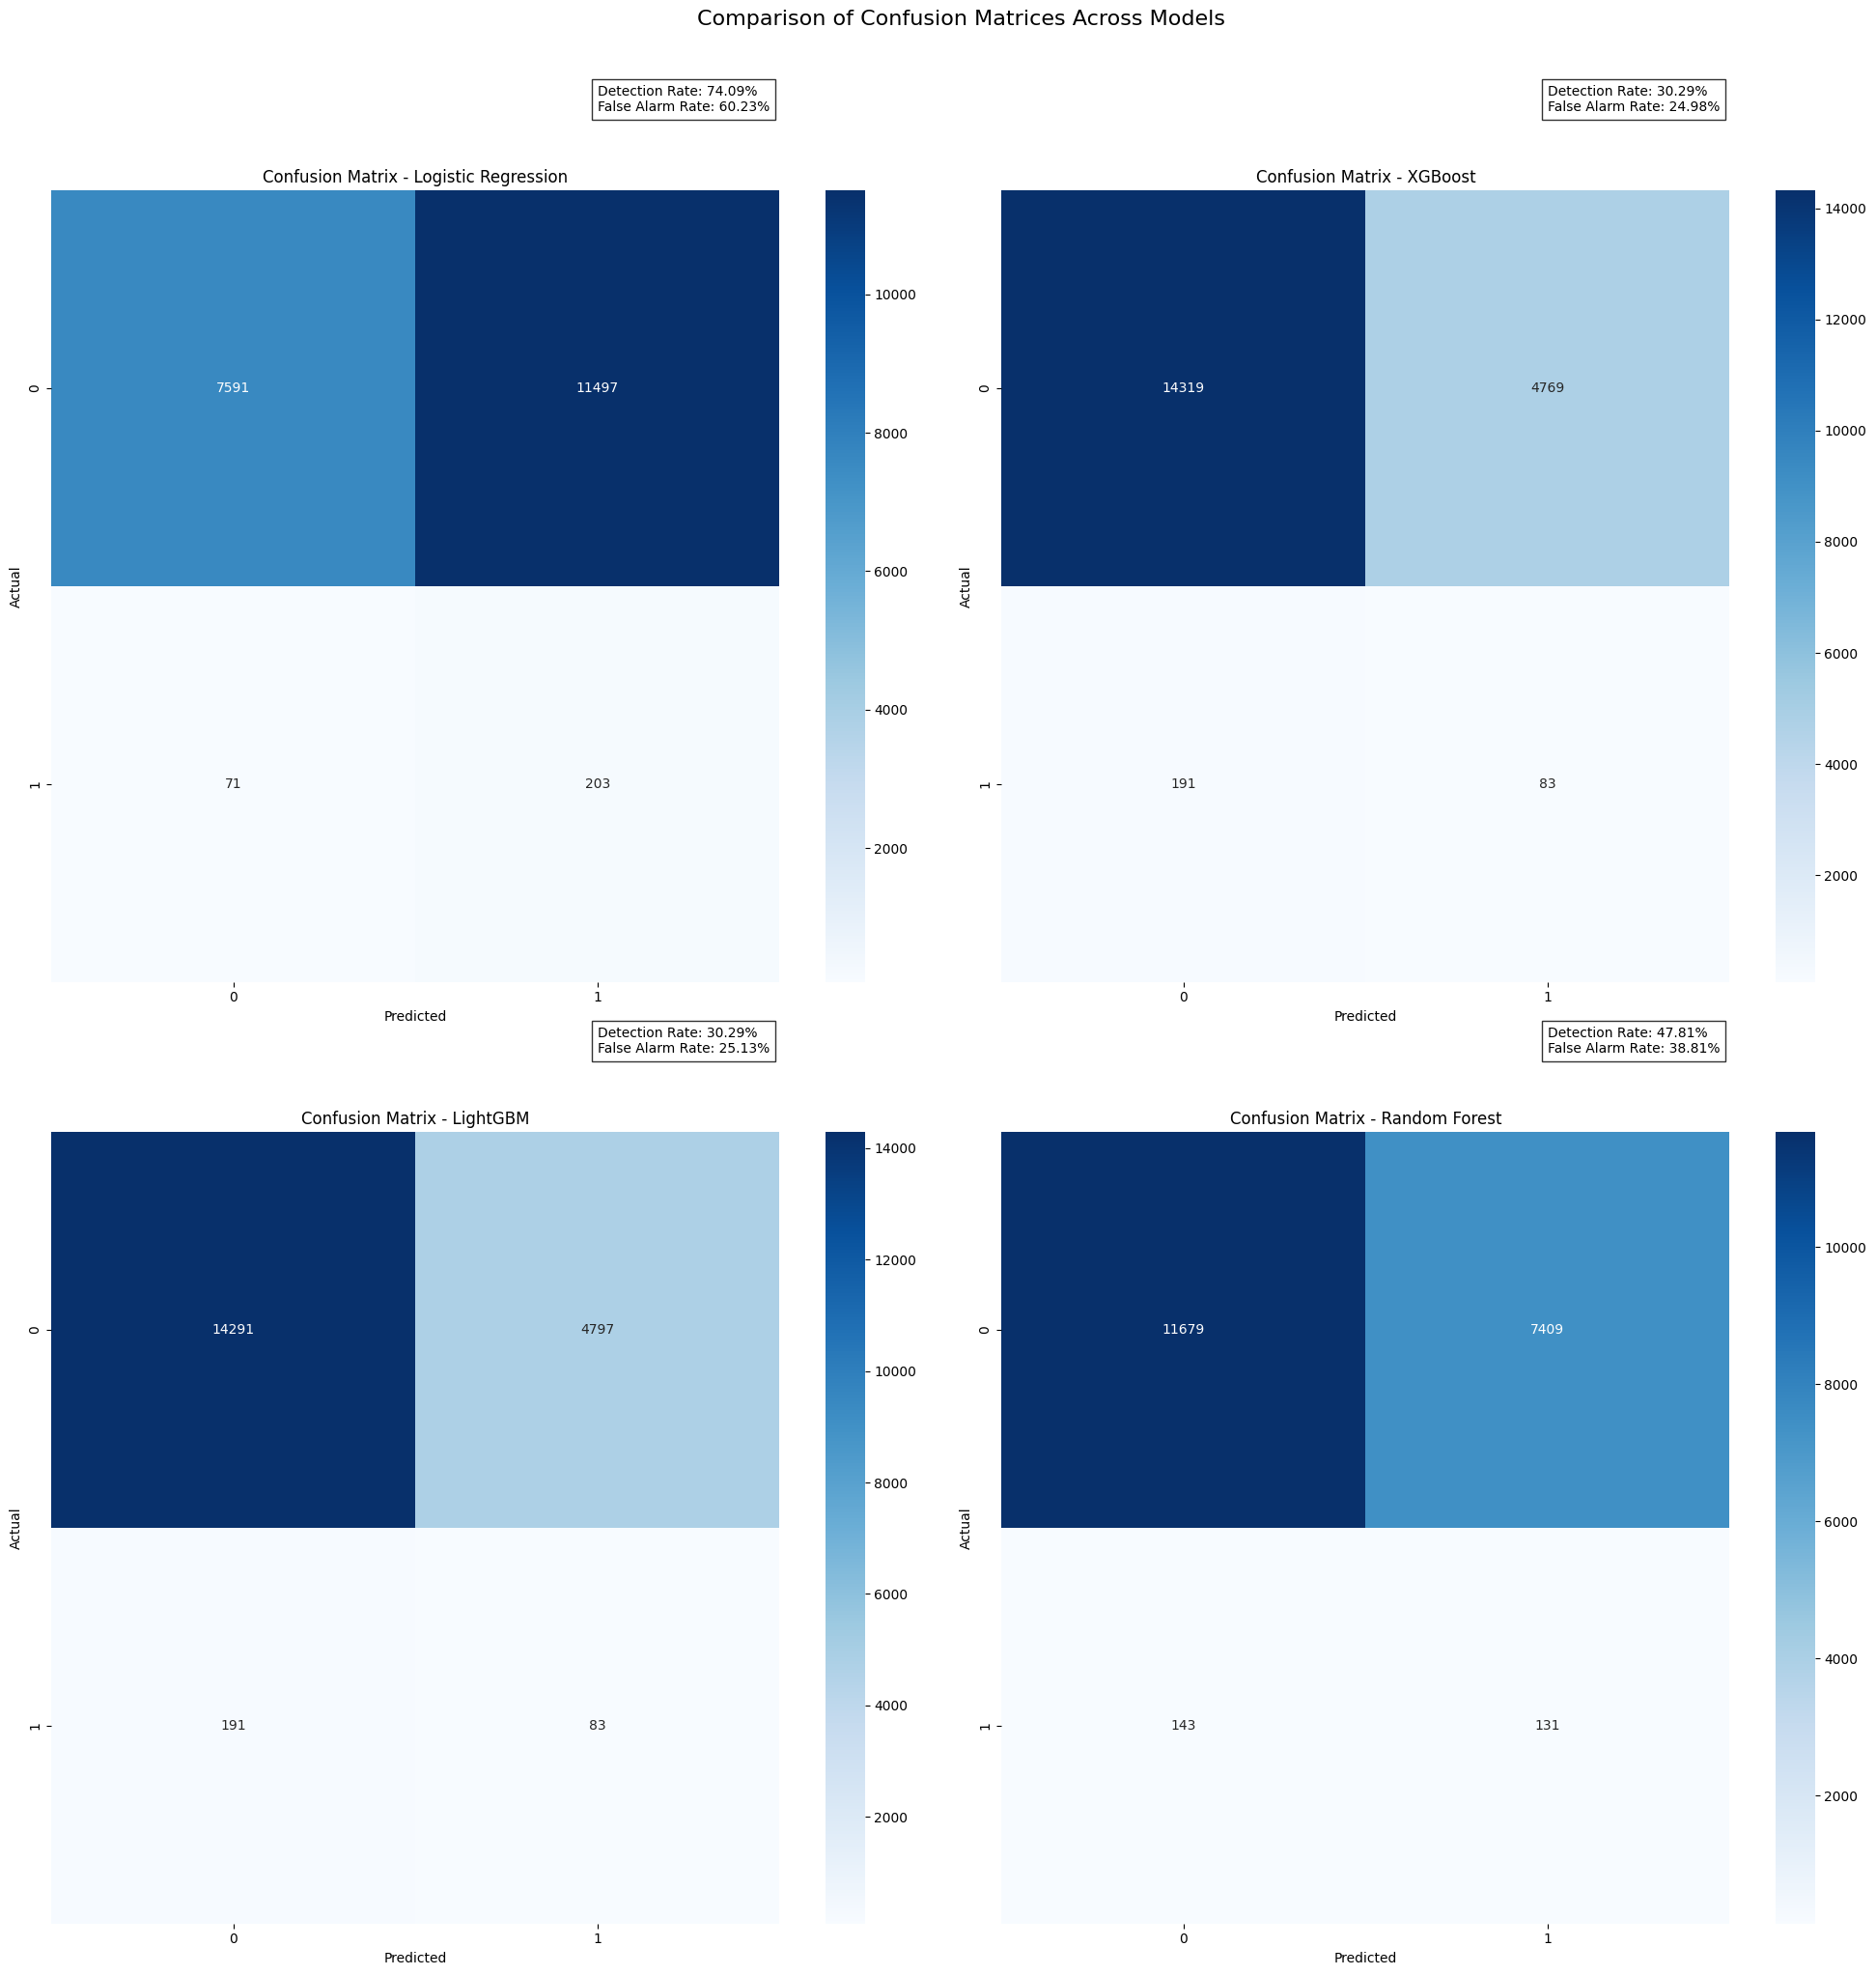

<Figure size 1200x600 with 0 Axes>

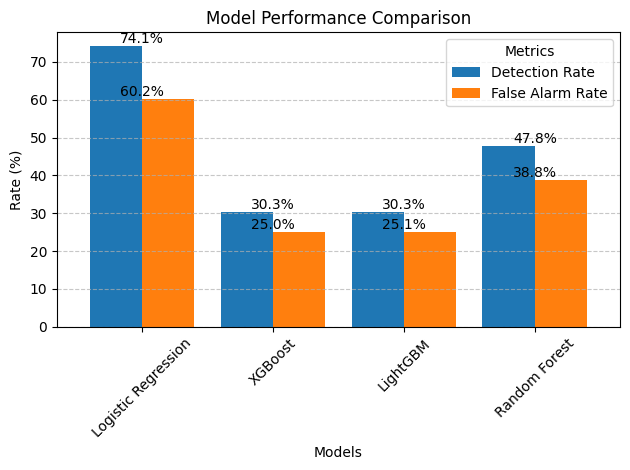

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

# Add LightGBM model (since it wasn't in the original code)
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_smote, y_train_smote)
y_pred_lgbm = lgbm.predict(X_test)

def plot_model_metrics(y_true, y_pred, model_name):
    """
    Create confusion matrix and anomaly count plots for a given model
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix ({model_name})')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Calculate rates
    tn, fp, fn, tp = cm.ravel()
    detection_rate = tp / (tp + fn) * 100
    false_alarm_rate = fp / (fp + tn) * 100

    text_box = f'Detection Rate: {detection_rate:.2f}%\nFalse Alarm Rate: {false_alarm_rate:.2f}%'
    ax1.text(1.5, -0.2, text_box, bbox=dict(facecolor='white', alpha=0.8))

    # Anomaly Count Distribution
    anomaly_counts = {
        'Normal (0)': (y_true == 0).sum(),
        'Anomaly (1)': (y_true == 1).sum()
    }

    bars = ax2.bar(anomaly_counts.keys(), anomaly_counts.values(), color=['lightblue', 'salmon'])
    ax2.set_title(f'Distribution of Normal vs Anomaly Cases\n({model_name})')
    ax2.set_ylabel('Count')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(y_true)*100:.1f}%)',
                ha='center', va='bottom')

    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print(f"\nDetailed Metrics for {model_name}:")
    print(f"Total Samples: {len(y_true)}")
    print(f"Normal Cases: {(y_true == 0).sum()} ({(y_true == 0).sum()/len(y_true)*100:.1f}%)")
    print(f"Anomaly Cases: {(y_true == 1).sum()} ({(y_true == 1).sum()/len(y_true)*100:.1f}%)")
    print(f"\nConfusion Matrix Details:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Detection Rate: {detection_rate:.2f}%")
    print(f"False Alarm Rate: {false_alarm_rate:.2f}%")
    print("-" * 50)

# Plot for Logistic Regression
plot_model_metrics(y_test, y_pred_lr, "Logistic Regression")

# Plot for XGBoost
plot_model_metrics(y_test, y_pred_xgb, "XGBoost")

# Plot for LightGBM
plot_model_metrics(y_test, y_pred_lgbm, "LightGBM")

# Create a combined visualization showing all models' confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Comparison of Confusion Matrices Across Models', fontsize=16, y=1.02)

# Flatten axes for easier iteration
axes = axes.ravel()

models = {
    'Logistic Regression': y_pred_lr,
    'XGBoost': y_pred_xgb,
    'LightGBM': y_pred_lgbm,
    'Random Forest': y_pred_rf
}

for idx, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

    # Add detection and false alarm rates
    tn, fp, fn, tp = cm.ravel()
    detection_rate = tp / (tp + fn) * 100
    false_alarm_rate = fp / (fp + tn) * 100

    text_box = f'Detection Rate: {detection_rate:.2f}%\nFalse Alarm Rate: {false_alarm_rate:.2f}%'
    axes[idx].text(1.5, -0.2, text_box, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Create a comparison bar plot of model performance metrics
model_metrics = {}
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    detection_rate = tp / (tp + fn) * 100
    false_alarm_rate = fp / (fp + tn) * 100
    model_metrics[name] = {
        'Detection Rate': detection_rate,
        'False Alarm Rate': false_alarm_rate
    }

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame(model_metrics).T

# Plot comparison
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Rate (%)')
plt.legend(title='Metrics')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add value labels on bars
for i in range(len(metrics_df)):
    for j in range(len(metrics_df.columns)):
        plt.text(i, metrics_df.iloc[i, j],
                f'{metrics_df.iloc[i, j]:.1f}%',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [39]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming val_data is your validation dataset and top_features is a list of selected features
X_val = val_data[top_features]  # Define X_val with selected features from the validation data

# Impute missing values in X_val
imputer = SimpleImputer(strategy='mean')  # You can change strategy to 'median' or 'most_frequent' as needed
X_val_imputed = imputer.fit_transform(X_val)

# Predict probabilities for validation data using Random Forest
val_pred_proba = rf.predict_proba(X_val_imputed)[:, 1]

# Predict probabilities for validation data using Logistic Regression
val_pred_proba1 = log_reg.predict_proba(X_val_imputed)[:, 1]

# Save the predictions for Random Forest
validation_results_RandomForest = pd.DataFrame({
    'account_number': val_data['account_number'],
    'predicted_probability': val_pred_proba
})

# Save the predictions for Logistic Regression
validation_results_LogisticRegression = pd.DataFrame({
    'account_number': val_data['account_number'],
    'predicted_probability': val_pred_proba1
})

# Save to CSV files
validation_results_RandomForest.to_csv('validation_predictions_RandomForest.csv', index=False)
print("Validation predictions saved as 'validation_predictions_RandomForest.csv'.")

validation_results_LogisticRegression.to_csv('validation_predictions_LogisticRegression.csv', index=False)
print("Validation predictions saved as 'validation_predictions_LogisticRegression.csv'.")



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Validation predictions saved as 'validation_predictions_RandomForest.csv'.
Validation predictions saved as 'validation_predictions_LogisticRegression.csv'.


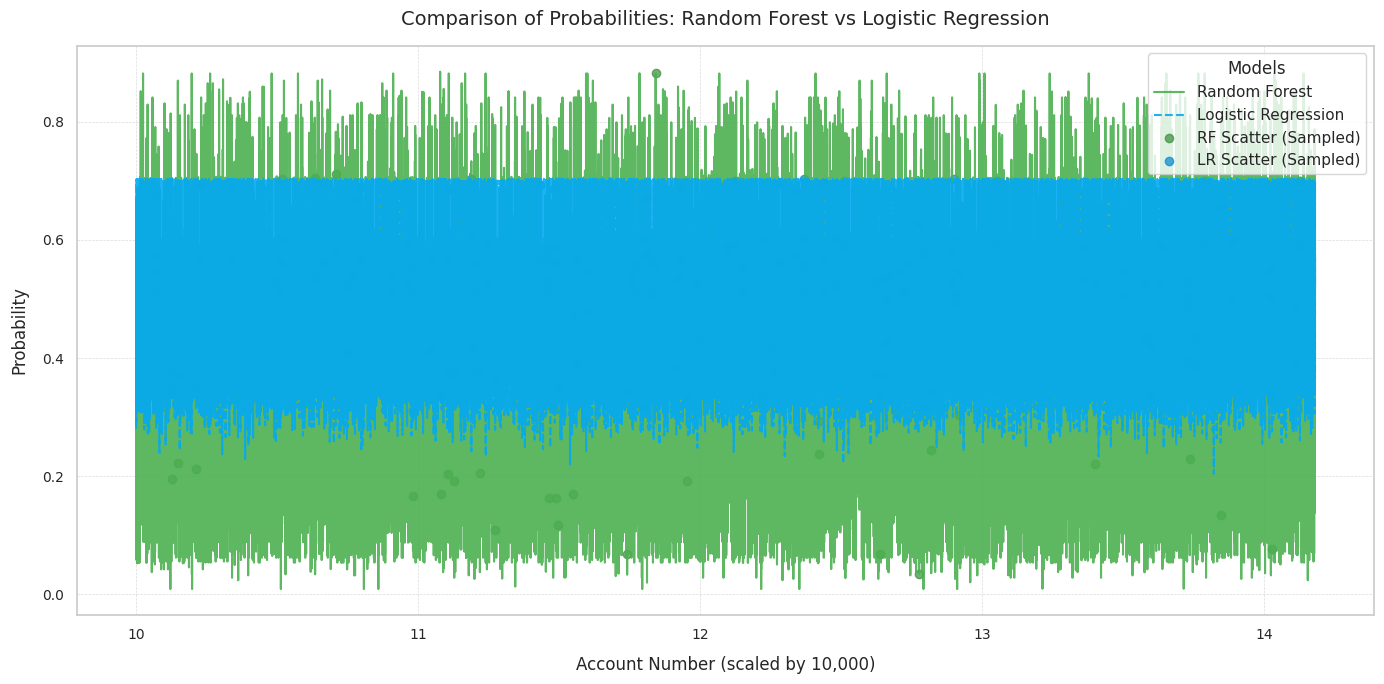

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the CSV files (replace 'random_forest.csv' and 'logistic_regression.csv' with your actual filenames)
rf_data = pd.read_csv('/content/validation_predictions_RandomForest.csv')
lr_data = pd.read_csv('/content/validation_predictions_LogisticRegression.csv')

# Ensure both files have columns named 'Account_No' and 'Probability'
rf_data.columns = ['Account_No', 'RF_Probability']
lr_data.columns = ['Account_No', 'LR_Probability']

# Merge the DataFrames on 'Account_No'
merged_data = pd.merge(rf_data, lr_data, on='Account_No')

# Scale the x-axis values (Account_No) by dividing by 10,000
merged_data['Scaled_Account_No'] = merged_data['Account_No'] / 10000

# Randomly select 100 points for scatter visualization
sampled_data = merged_data.sample(100, random_state=42)

# Set a modern plot style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Plot lines for all data
plt.plot(
    merged_data['Scaled_Account_No'],
    merged_data['RF_Probability'],
    label='Random Forest',
    linestyle='-',
    color='#4CAF50',  # Elegant green
    alpha=0.9
)
plt.plot(
    merged_data['Scaled_Account_No'],
    merged_data['LR_Probability'],
    label='Logistic Regression',
    linestyle='--',
    color='#03A9F4',  # Calm blue
    alpha=0.9
)

# Add scatter points for only 100 sampled data points
plt.scatter(
    sampled_data['Scaled_Account_No'],
    sampled_data['RF_Probability'],
    color='#388E3C',  # Darker green for RF scatter
    label='RF Scatter (Sampled)',
    alpha=0.7
)
plt.scatter(
    sampled_data['Scaled_Account_No'],
    sampled_data['LR_Probability'],
    color='#0288D1',  # Darker blue for LR scatter
    label='LR Scatter (Sampled)',
    alpha=0.7
)

# Add labels, title, and legend
plt.xlabel('Account Number (scaled by 10,000)', fontsize=12, labelpad=10)
plt.ylabel('Probability', fontsize=12, labelpad=10)
plt.title('Comparison of Probabilities: Random Forest vs Logistic Regression', fontsize=14, pad=15)
plt.legend(title="Models", fontsize=11, title_fontsize=12, loc='upper right', frameon=True)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a grid and adjust layout
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


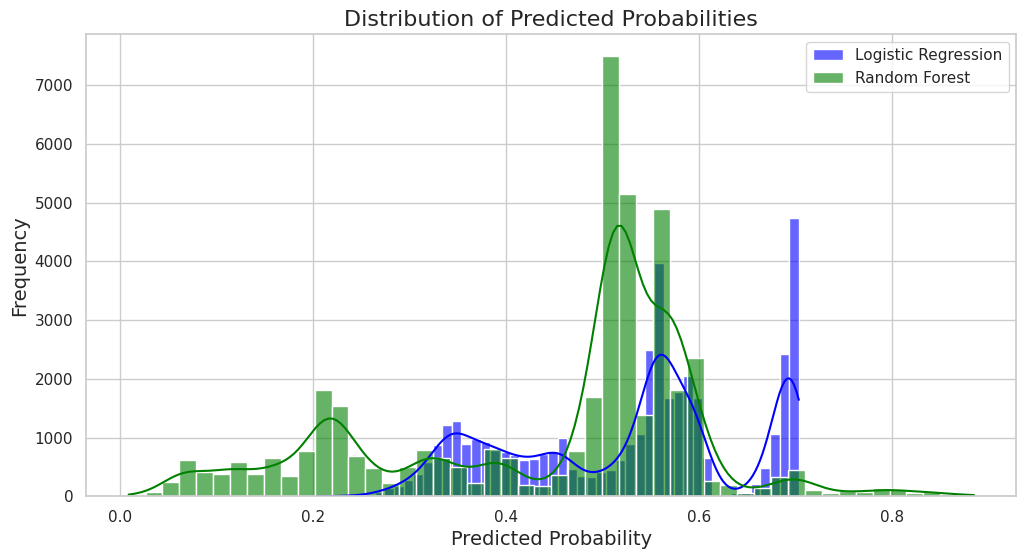

<Figure size 640x480 with 0 Axes>

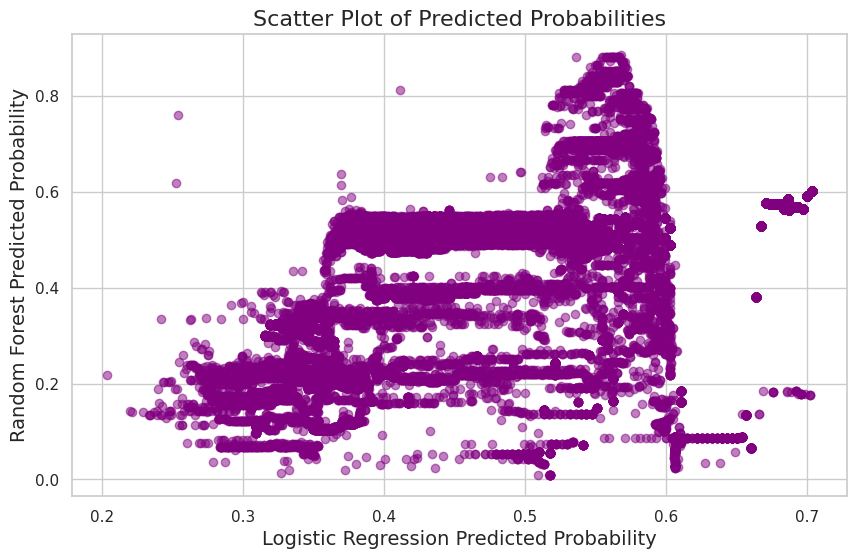

<Figure size 640x480 with 0 Axes>

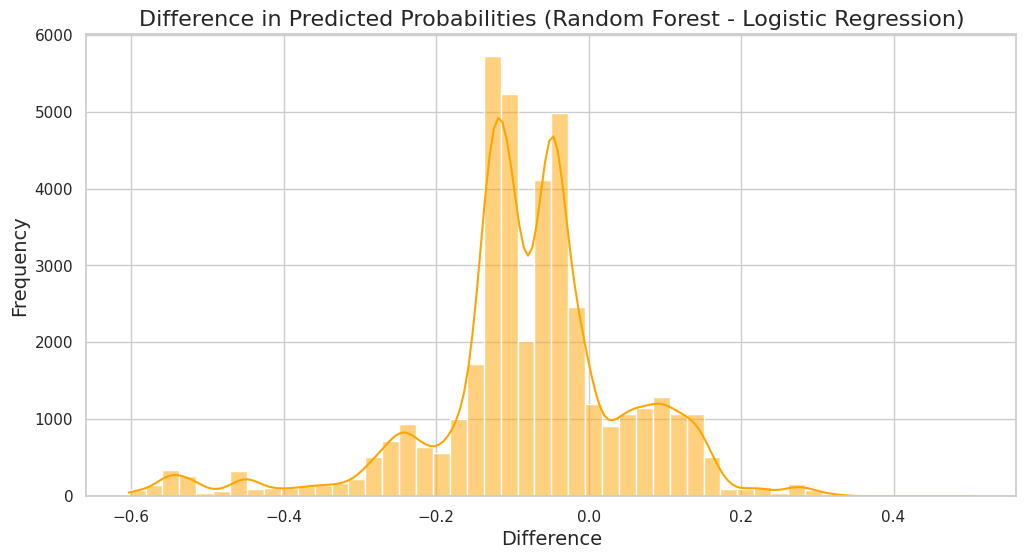

Correlation between Logistic Regression and Random Forest predictions: 0.5906


<ipython-input-66-7cb450801e0e>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='account_number', y='difference', data=largest_diff, palette='viridis')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

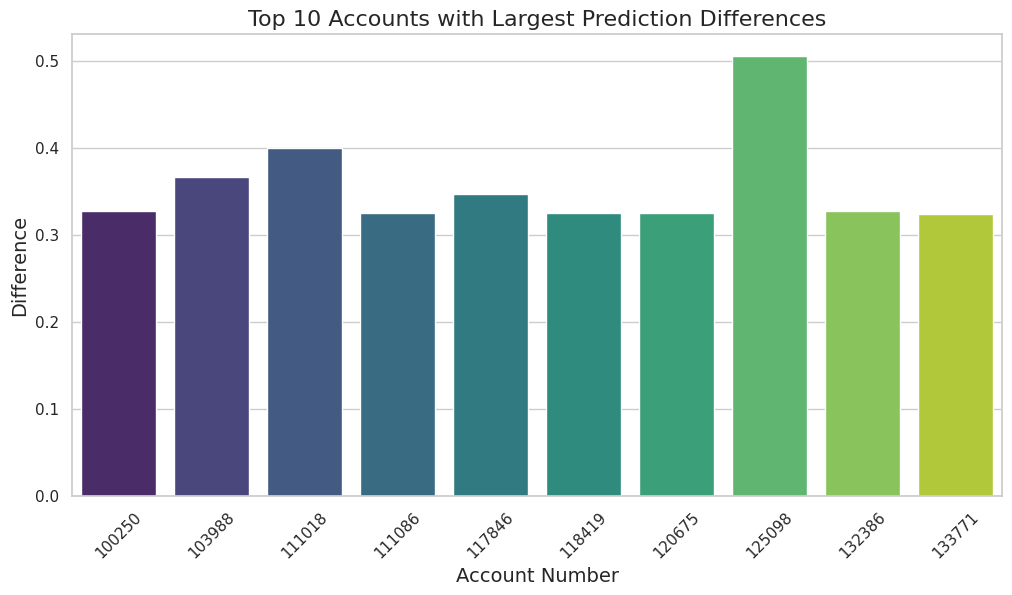

<ipython-input-66-7cb450801e0e>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Logistic Regression', 'Random Forest'], y=[mean_lr, mean_rf], palette='coolwarm')


<Figure size 640x480 with 0 Axes>

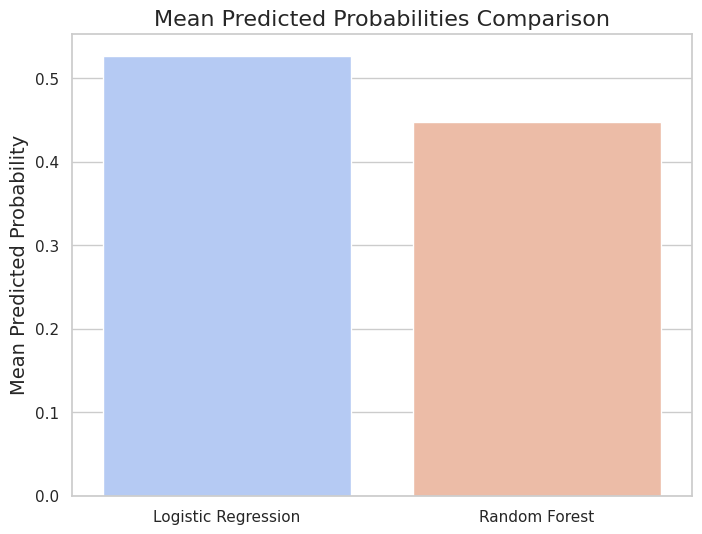

In [66]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_lr = '/content/validation_predictions_LogisticRegression.csv'
file_rf = '/content/validation_predictions_RandomForest.csv'

df_lr = pd.read_csv(file_lr)
df_rf = pd.read_csv(file_rf)

# Merge the data on account_number
merged_df = df_lr.merge(df_rf, on='account_number', suffixes=('_lr', '_rf'))

# 1. Distribution of Predicted Probabilities (Histogram)
plt.figure(figsize=(12, 6))
sns.histplot(df_lr['predicted_probability'], bins=50, kde=True, color='blue', label='Logistic Regression', alpha=0.6)
sns.histplot(df_rf['predicted_probability'], bins=50, kde=True, color='green', label='Random Forest', alpha=0.6)
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()

# Add spacing between plots
plt.figure().clear()

# 2. Scatter Plot of Predictions
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['predicted_probability_lr'], merged_df['predicted_probability_rf'], alpha=0.5, color='purple')
plt.title('Scatter Plot of Predicted Probabilities', fontsize=16)
plt.xlabel('Logistic Regression Predicted Probability', fontsize=14)
plt.ylabel('Random Forest Predicted Probability', fontsize=14)
plt.grid(True)
plt.show()

# Add spacing between plots
plt.figure().clear()

# 3. Difference in Predictions
merged_df['difference'] = merged_df['predicted_probability_rf'] - merged_df['predicted_probability_lr']
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['difference'], bins=50, kde=True, color='orange')
plt.title('Difference in Predicted Probabilities (Random Forest - Logistic Regression)', fontsize=16)
plt.xlabel('Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Add spacing between plots
plt.figure().clear()

# 4. Correlation Analysis
correlation = merged_df[['predicted_probability_lr', 'predicted_probability_rf']].corr().iloc[0, 1]
print(f'Correlation between Logistic Regression and Random Forest predictions: {correlation:.4f}')

# Add spacing between plots
plt.figure().clear()

# 5. Highlight Accounts with Largest Differences
largest_diff = merged_df.nlargest(10, 'difference')
plt.figure(figsize=(12, 6))
sns.barplot(x='account_number', y='difference', data=largest_diff, palette='viridis')
plt.title('Top 10 Accounts with Largest Prediction Differences', fontsize=16)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Difference', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Add spacing between plots
plt.figure().clear()

# 6. Mean Predicted Probabilities Comparison
mean_lr = df_lr['predicted_probability'].mean()
mean_rf = df_rf['predicted_probability'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=['Logistic Regression', 'Random Forest'], y=[mean_lr, mean_rf], palette='coolwarm')
plt.title('Mean Predicted Probabilities Comparison', fontsize=16)
plt.ylabel('Mean Predicted Probability', fontsize=14)
plt.show()
